# Bio Signal Workshop 2022

Submission by Gaffar and Tobias

During the workshop, our task was to
- Design an experiment to measure different cognitive load levels
- Conduct the experiment and collect data from all participants of our workshop group
- Preprocess the data
- Extract features for machine learning
- Classify different cognitive load levels via machine learning
- [Create an online system prototype]

Throughout the course, we were working with Unicorn Hybrid Black devices. 

<img src="https://www.unicorn-bi.com/wp-content/uploads/2018/12/unicorn-newslide-05.jpg" alt="Unicorn EEG" title="Unicorn EEG" width="250"/>

These EEGs offer eight electrodes, sampled with 250 Hz per channel.

A layout of the electrodes is shown two cells below.

In [1]:
%matplotlib inline

from IPython.display import Image
from itertools import product
from matplotlib import colors
from mne.time_frequency import psd_welch
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import  GridSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import export_graphviz
from subprocess import call
import glob
import logging
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import pyxdf
import re
import shap 
import xgboost as xgb


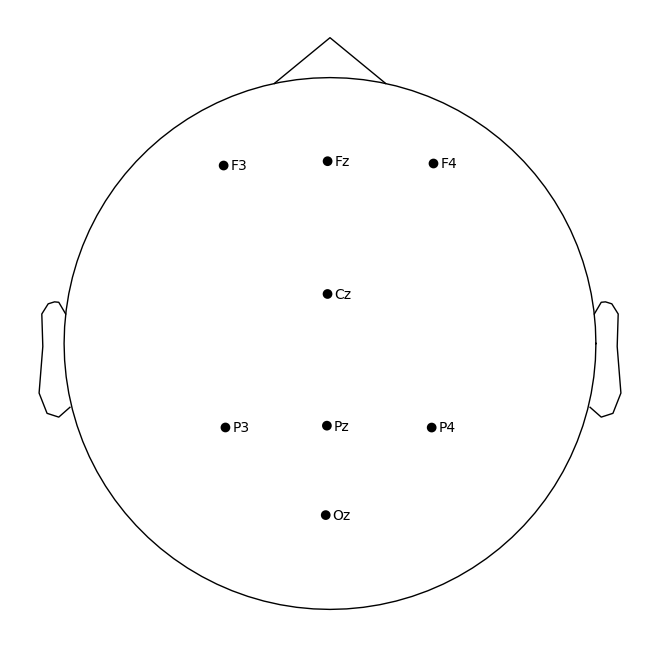

In [2]:
mont1020 = mne.channels.make_standard_montage('standard_1020')
kept_channels = ['Fz', 'Cz', 'Pz', 'Oz', 'F3', 'F4', 'P3', 'P4']
ind = [i for (i, channel) in enumerate(mont1020.ch_names) if channel in kept_channels]
mont1020_new = mont1020.copy()

# Keep only the desired channels
mont1020_new.ch_names = [mont1020.ch_names[x] for x in ind]
kept_channel_info = [mont1020.dig[x+3] for x in ind]

# Keep the first three rows as they are the fiducial points information
mont1020_new.dig = mont1020.dig[0:3]+kept_channel_info
mont1020_new.plot();

## Experiment

Our goal was to measure cognitive load by means of multitasking with increasing difficulty.

It comprises y=3 trials with 3 stages each. The three trials start automatically after each other.

Per stage, the duration is x=40 seconds 

Between the stages participants take a break of p=40 seconds. 

An automatic timer tracks these breaks and counts down between the stages.

Randomization of the stages ensures external validity.

We make use of a Unity environment which looks like this:

![CL Experiment](preview_cl.PNG)

### Experiment summary
* We ensure a quiet environment with only two persons in the room: subject and experimenter
* To minimize signal noise,
  * participants are told to move as little as possible
  * experimenter clicks the answers which the participants speak out loud
* We record Baseline of x=40 seconds duration. During this period, participants look outside the window.
* The tasks consist of three inclusive difficulty levels and also last x=40 seconds each: 
  * trace ball 
  * trace ball and calculate sum 
  * trace ball and calculate sum and track turning wheel
* Participant make y=3 trials (1 trial = all three difficulty levels in a row)
* between the trials participants take a break of p=40 seconds.

### Software workflow
* Start unicorn suite hybrid black
* Connect EEG (see MAC address on the back side of the device, e.g. UN-2021.12.35)
* Start Unicorn recorder and check signal visually
* Start Unity experiment software
* Start Unicorn lsl
* Define stream name as "eeg"
* Start stream
* Start LSL recorder
* Save "eeg" and "markers" streams (baseline as own file and experiment as own file)

## Data preparation

In [3]:
# Setup logging
# Set to ERROR to suppress warnings about empty streams

# Background: 
# Some recordings contain empty streams of length 0 (additionally to "eeg" and "markers")
# A warning occurs when reading them via pyxdf.
# We filter these streams after loading the data by checking for the stream length.

logFormatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logging.basicConfig(level=logging.ERROR)
logger = logging.getLogger(__name__)

In [4]:
# Load data 
# The files can be separated by the Session ID
# Files with session identifier S001 contain baseline recordings
# Files with session identifier S002 contain experiment recordings

def load_data(path: str):
    tmp = []
    for file in glob.glob(path, recursive=True):
        tmp.append(file)
    return tmp


# load baseline file names
baseline_list = load_data('data/**/*S001*.xdf')
current_baseline_list = [x for x in baseline_list if 'Tobias' in x]
print(current_baseline_list)

# load experiment file names
experiment_list = load_data('data/**/*S002*.xdf')
current_experiment_list = [x for x in experiment_list if 'Tobias' in x]
print(current_experiment_list)


['data/gme2022/sub-Tobias/ses-S001/eeg/sub-Tobias_ses-S001_task-Default_run-001_eeg.xdf']
['data/gme2022/sub-Tobias/ses-S002/eeg/sub-Tobias_ses-S002_task-Default_run-001_eeg.xdf']


In [5]:
# Read baseline function

def read_baseline(current_baseline_list):
    """ Convert the data into a RawArray Object.
        To this end a "info" object has to be created, 

    Parameters
    ----------
    current_baseline_list : list of strings
        The list of filenames to read.

    Returns
    -------
    current_baseline_mne_list : list of RawArrays
        Loaded data in format of the MNE toolkit.
    """

    current_baseline_mne_list = []

    sfreq = 250
    info = mne.create_info(8, sfreq, ["eeg"] * 8)

    for baseline in current_baseline_list:
        streams, _ = pyxdf.load_xdf(baseline)
        try:
            data = streams[1]["time_series"].T[:8]
        except AttributeError:
            # some recordings miss the marker channel
            # in this case "eeg" 
            data = streams[0]["time_series"].T[:8]
        raw = mne.io.RawArray(data, info, verbose=False)
        raw = raw.crop(tmin=1, tmax=41)
        current_baseline_mne_list.append(raw)
    return current_baseline_mne_list

# check if the function works as expected by performing a load
current_baseline_mne_list = read_baseline(current_baseline_list)
print(current_baseline_mne_list)

[<RawArray | 8 x 10001 (40.0 s), ~638 kB, data loaded>]


In [6]:
# read trials

def read_trails(current_experiment_list: list, current_baseline_list: list) -> dict:
    """ Read all trias and the baseline of one or more subjects.
        Put the converted data into a dictionary with a key for each treatment.

    Parameters
    ----------
    current_experiment_list : list of strings
        The list of experiment filenames to read.
    current_baseline_list : list of strings
        The list of baseline filenames to read.

    Returns
    -------
    trials : dict
        Lists of RawArray MNE Objects of all trials and baselines seperated by their type.
    """

    trials = { 
            'ball': list(),
            'ball+number': list(),
            'ball+number+wheel': list(),
            'baseline': read_baseline(current_baseline_list),
            }

    for experiment in current_experiment_list:

        streams, _ = pyxdf.load_xdf(experiment)

        # The index for the two relevant channels changes for different recordings
        # Determine which is the marker and eeg stream
        marker = -1 
        eeg = -1
        for idx, stream in enumerate(streams):
            if streams[idx]['time_stamps'].shape[0] == 0:
                continue # ignore empty streams
            if stream["info"]["name"] == ["markers"]:
                marker = idx
            elif stream["info"]["name"] == ["eeg"]:
                eeg = idx
            else:
                raise Exception(f"stream info name unknown {stream['info']['name']}")
        if marker == -1 or eeg == -1:
            raise Exception('channels not found') # eeg or marker stream not found
        
        for i in range(0, streams[marker]["time_stamps"].shape[0], 2):
            # Get start and stop markers for relevant events
            event = streams[marker]["time_series"][i][0] # event name as string
            if event in ['Starting Complex Eye Tracking Dashboard', 'Starting Simple Eye Tracking Dashboard', '']:
                continue # ignore irrelevant events
            start = streams[marker]["time_stamps"][i] # start time of relevant event
            stop = streams[marker]["time_stamps"][i+1]

            # collect all data for this event
            data = []
            for j, stamp in enumerate(streams[eeg]["time_stamps"]):
                if start <= stamp and stamp <= stop: 
                    data.append(streams[eeg]["time_series"][j])
            data = np.array(data).T[:8]

            # convert into MNE RawArray object
            sfreq = 250
            info = mne.create_info(8, sfreq, ["eeg"] * 8)
            trial = mne.io.RawArray(data, info, verbose=False)

            # determine correct key/label
            if event == 'Starting Cognitive Load Tasks: Balls True, Numbers False, Wheel False':
                key = 'ball'
            elif event == 'Starting Cognitive Load Tasks: Balls True, Numbers True, Wheel False':
                key = 'ball+number'
            elif event == 'Starting Cognitive Load Tasks: Balls True, Numbers True, Wheel True':
                key = 'ball+number+wheel'
            else:
                print(f"key {event} not defined!")

            trials[key].append(trial)
        
    return trials

# test the function and read current list
trials = read_trails(current_experiment_list, current_baseline_list) 

# Descriptive analysis and preprocessing

We discuss following topics:
* Power line noise
* Bad channels / artifacts
* Baseline correction (BC)

Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
Channel locations not available. Disabling spatial colors.


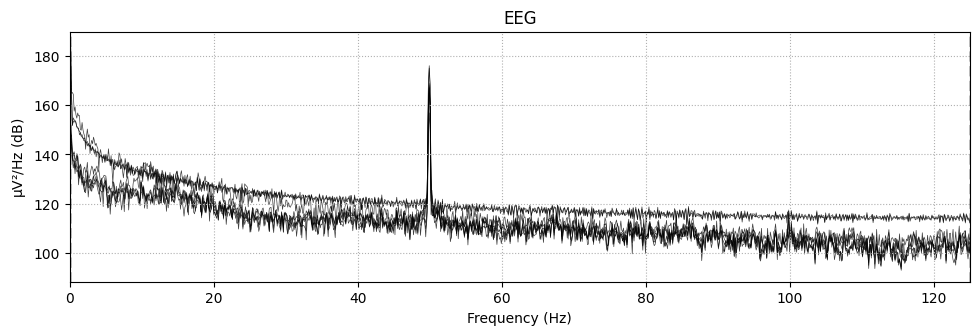

In [7]:
# Plot psd (power spectral density) with power line noise
# The power line noise is the peak at 50 Hz.
# Note that all multiples of 50 Hz (here 100 Hz) are also affected

raw = current_baseline_mne_list[0]
raw.plot_psd(tmax=np.inf, fmax=125);


Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
Channel locations not available. Disabling spatial colors.


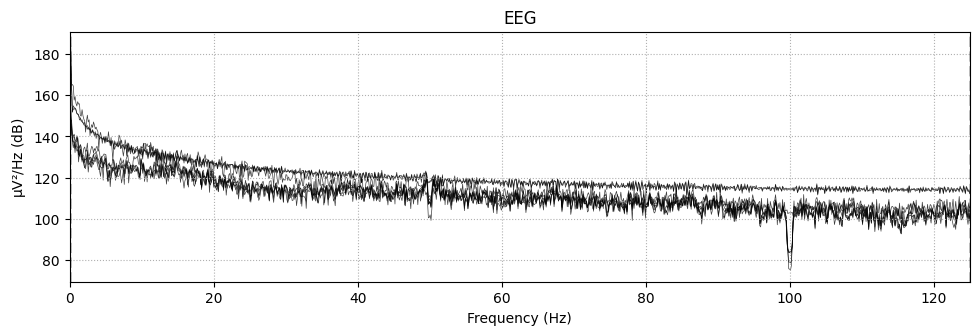

In [8]:
# Filter power line noise and plot psd
# Using the notch filter with an appropriate width (here 0.5) the peaks can me eliminated

freqs = (50, 100)
raw_notch = raw.copy().notch_filter(freqs=freqs, verbose=False, notch_widths=0.5)
raw_notch.plot_psd(tmax=np.inf, fmax=125);


<RawArray | 8 x 10001 (40.0 s), ~638 kB, data loaded>
Setting up band-stop filter from 2 - 60 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 2.00, 60.00 Hz: -6.02, -6.02 dB

Using matplotlib as 2D backend.


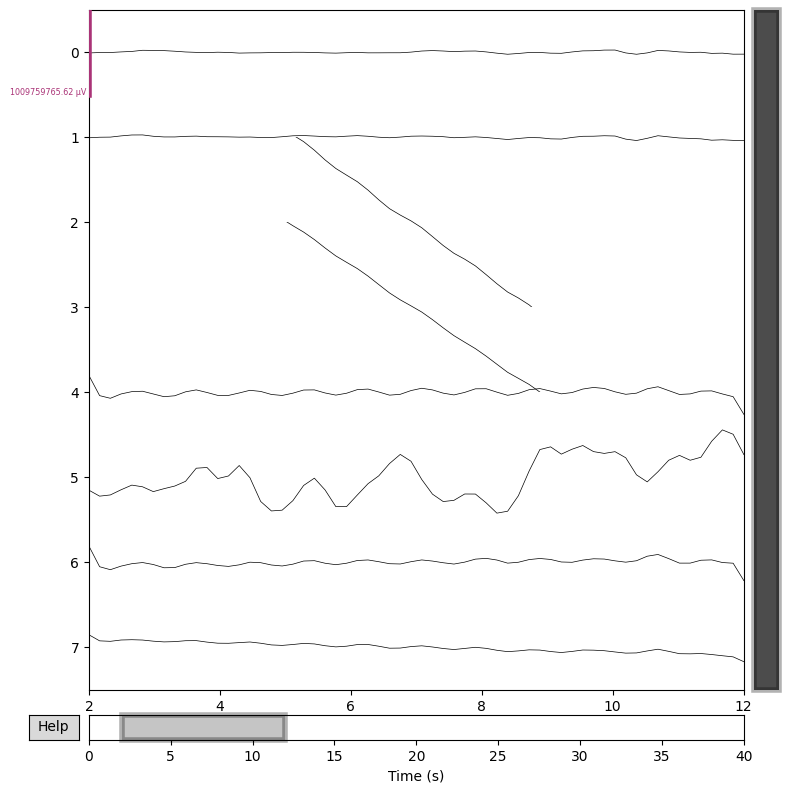

In [9]:
# Show bad channel example
# Notice the missing/skewed values for channel 2 and 3
# It is too long for a blink. Could be related to movement?!

raw = current_baseline_mne_list[0]
print(raw)
raw.plot(scalings='auto', duration=10, start=2, n_channels=8, highpass=60, lowpass=2, clipping='transparent');

<RawArray | 8 x 10001 (40.0 s), ~638 kB, data loaded>
ch  name  type  unit        min         Q1     median         Q3        max
 0  0     EEG   µV    216116171875.00  216183312500.00  216211109375.00  216238203125.00  216318578125.00
 1  1     EEG   µV    198510406250.00  198623781250.00  198689671875.00  198756906250.00  198883500000.00
 2  2     EEG   µV    343870062500.00  347976343750.00  352415687500.00  357466187500.00  363480875000.00
 3  3     EEG   µV    338257625000.00  342202437500.00  346463937500.00  351243093750.00  356817187500.00
 4  4     EEG   µV    180593703125.00  180760437500.00  181016765625.00  181274718750.00  181453171875.00
 5  5     EEG   µV    158166671875.00  158981171875.00  160792375000.00  161212500000.00  161668484375.00
 6  6     EEG   µV    207878921875.00  208076515625.00  208303781250.00  208533656250.00  208694765625.00
 7  7     EEG   µV    170864078125.00  171176906250.00  171331500000.00  171488765625.00  171841468750.00
Describe:  None


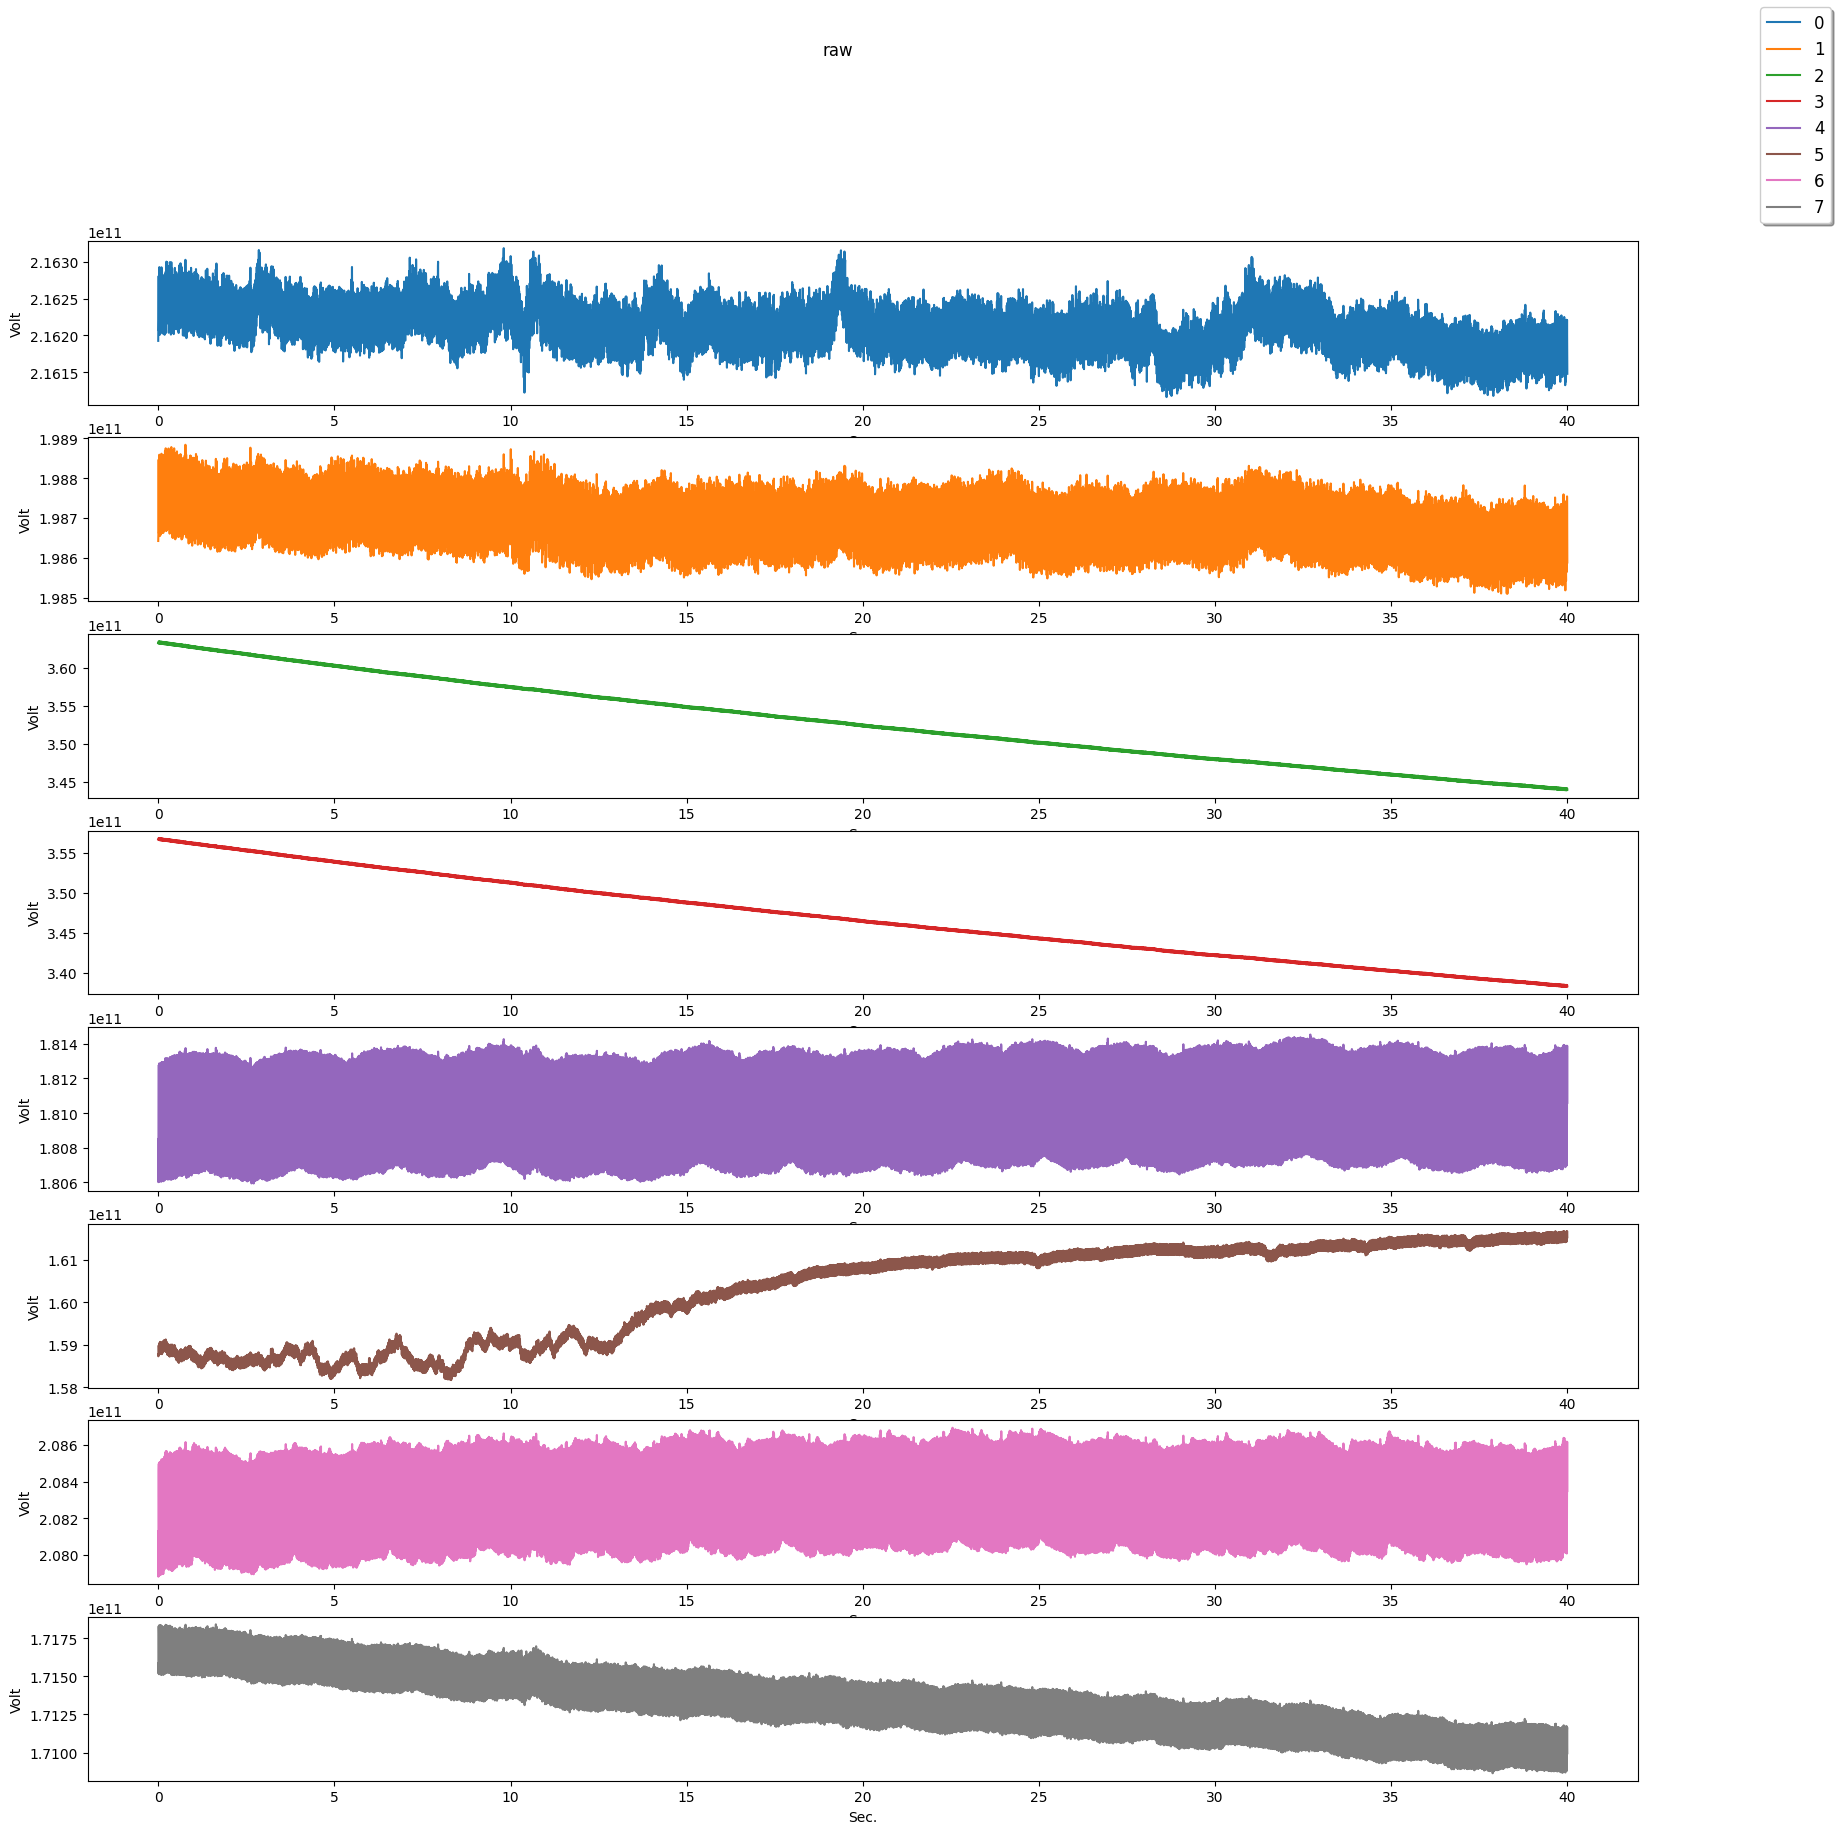

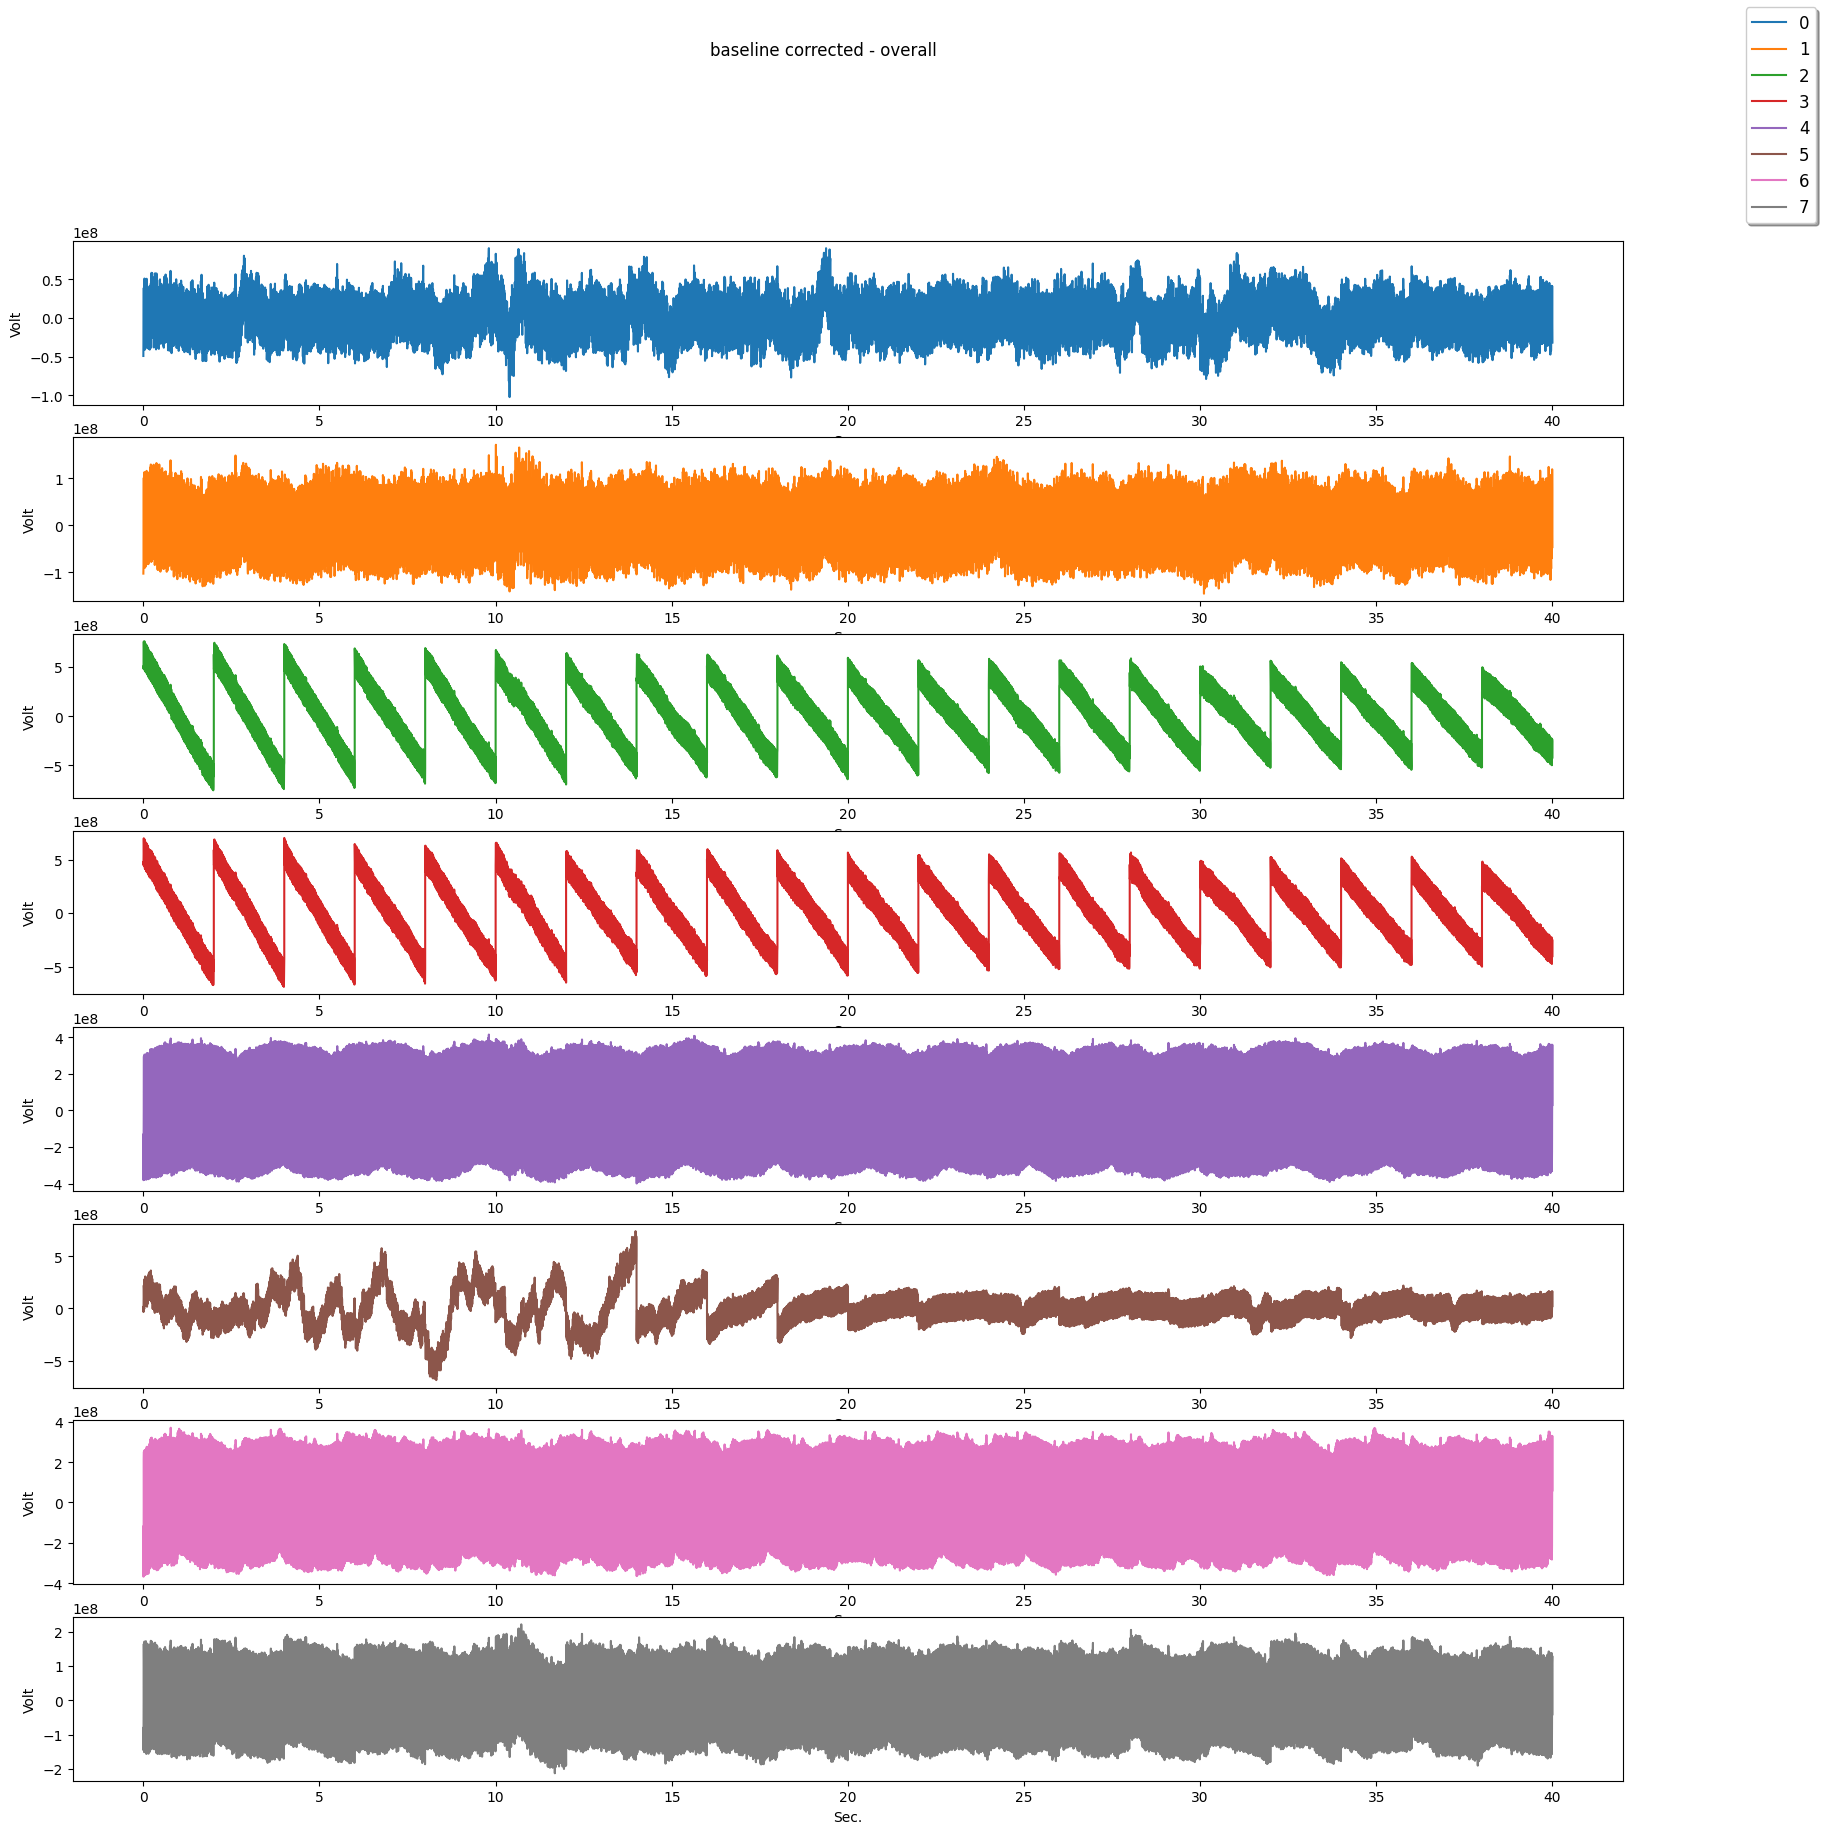

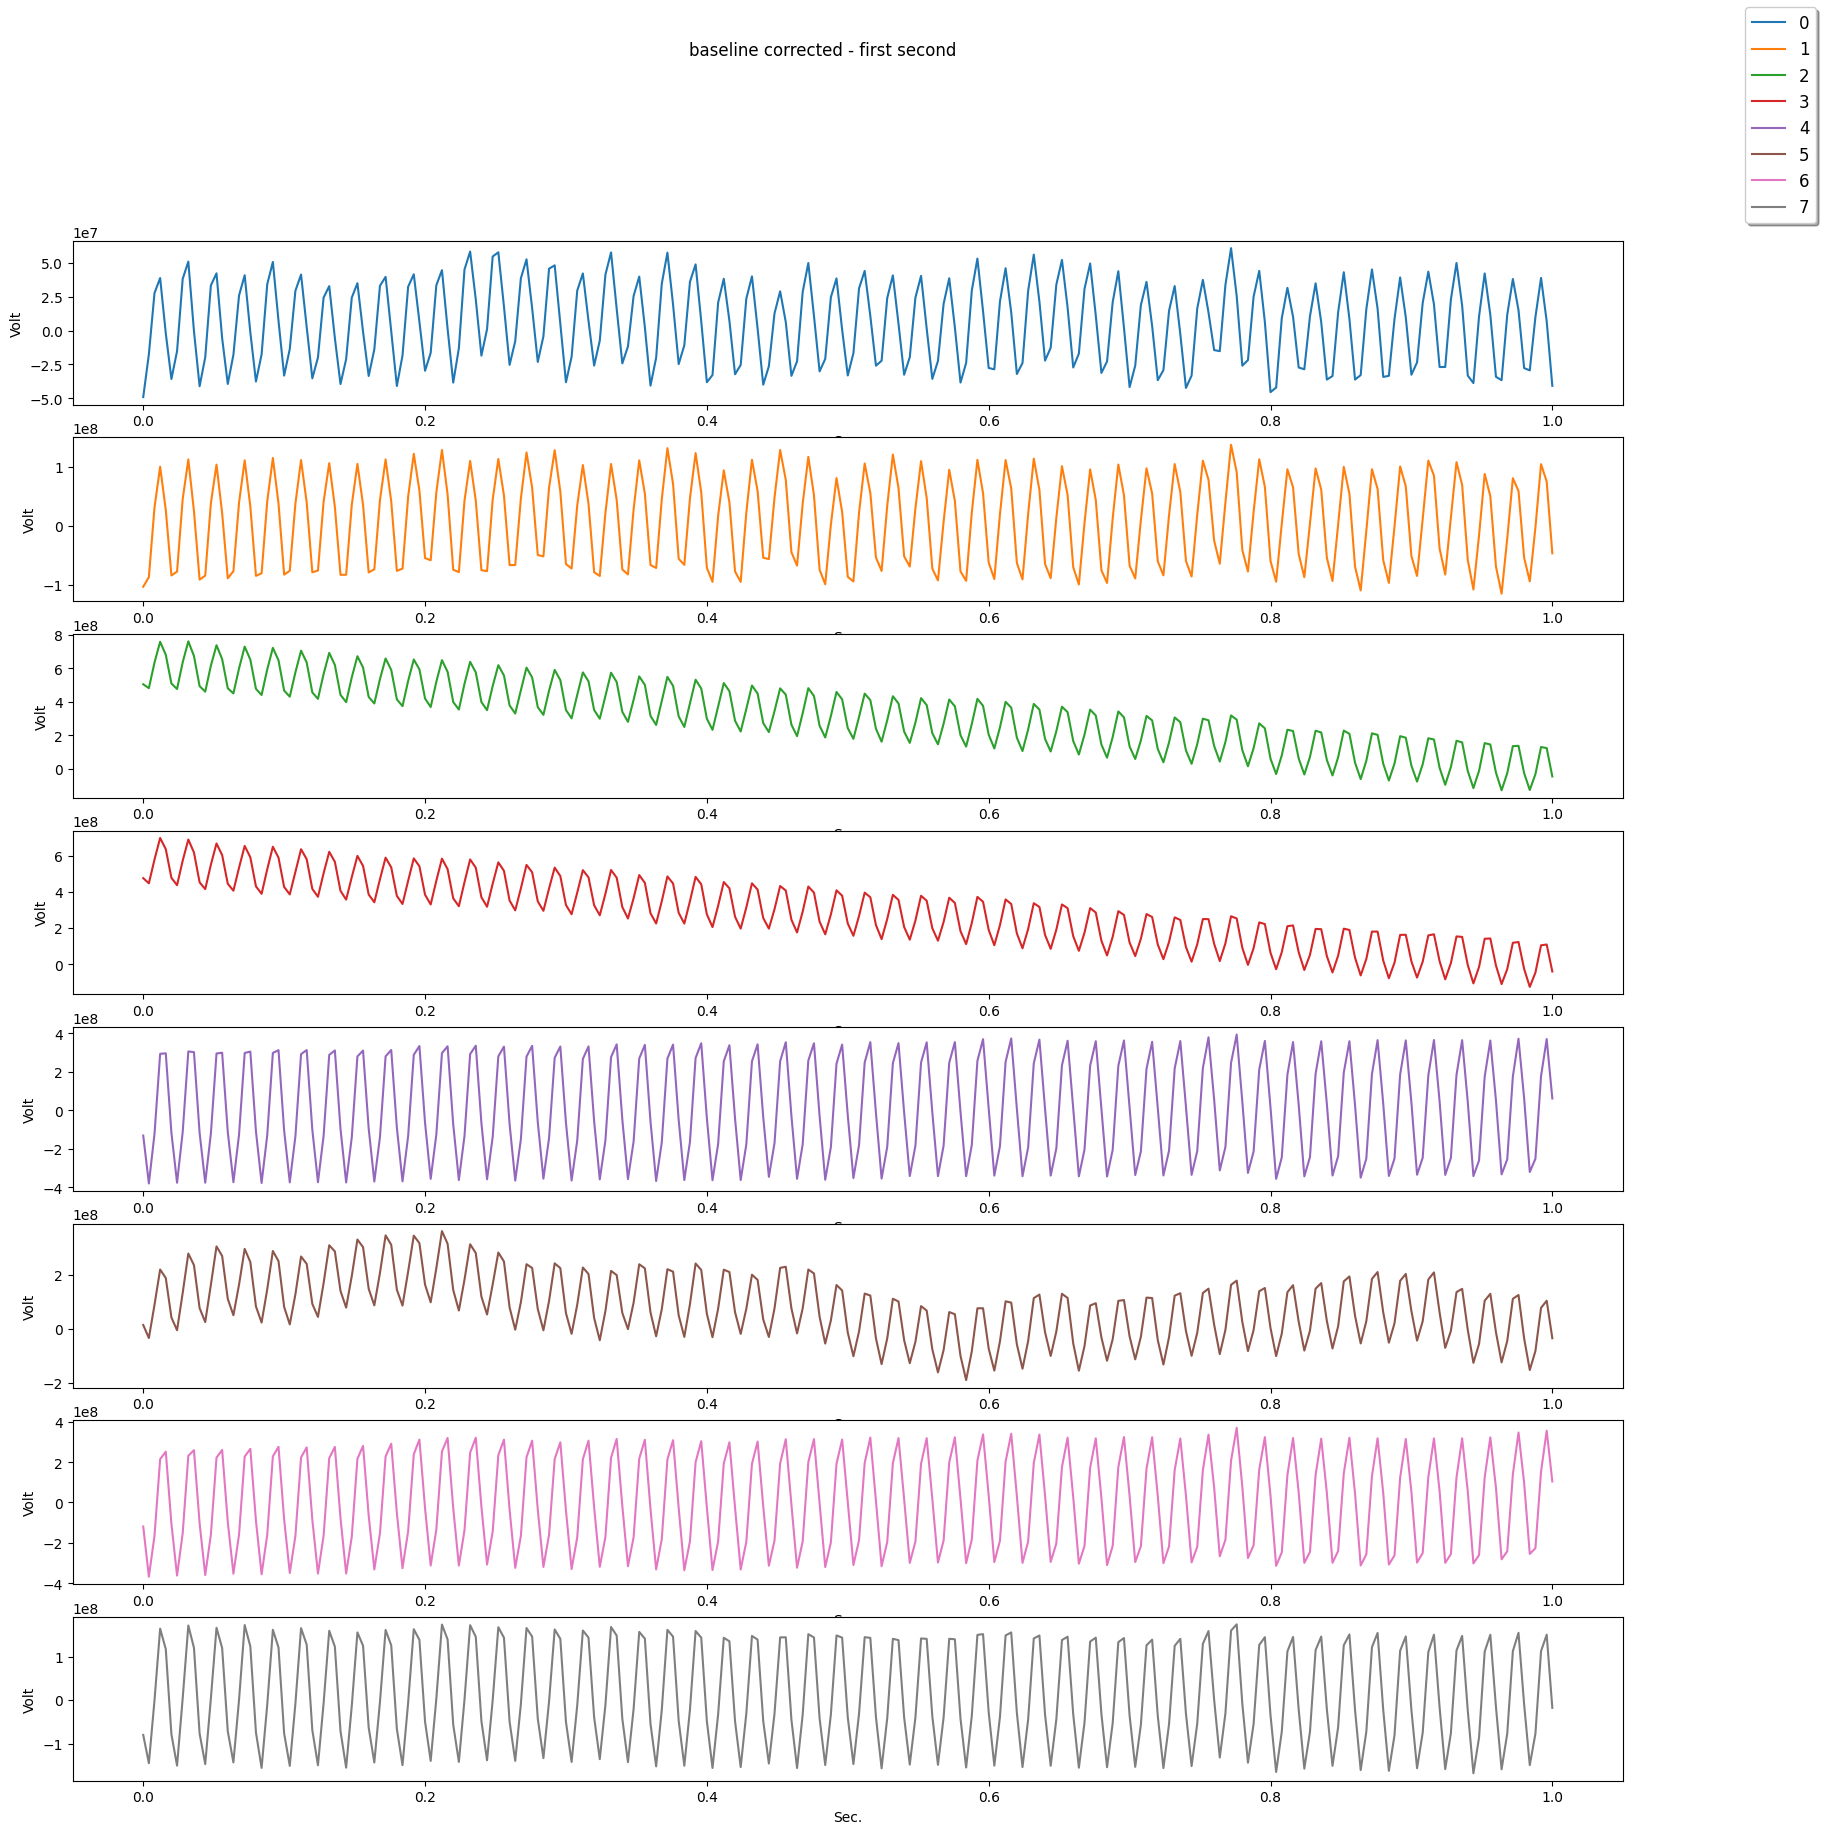

In [10]:
# Baseline correction (BC)
# We perform BC by converting the data into a vanilla pandas dataframe.
# By using a two second window, we calculate the mean value for each channel and substract it from each observation.
# For general BC info, see https://neuro.inf.unibe.ch/AlgorithmsNeuroscience/Tutorial_files/BaselineCorrection.html

def plotChannel(df: pd.DataFrame, title, tmin=0.0, tmax=40.0):
    """ Plot all channels of a EEG signal in form of a pandas DataFrame.

    Parameters
    ----------
    df : DataFrame
        EEG data.
    title : string
        Plot title.
    tmin : float
        Start time for plot.
    tmax : float
        Stop time for plot.

    Returns
    -------
    None
    """
    fig, ax = plt.subplots(len(df.columns), figsize=(20, 20))

    for i, col in enumerate(df.columns):   
        ax[i].plot(df[(df.index >= tmin) & (df.index <= tmax)][col], label=col, color=[x for x in colors.TABLEAU_COLORS.values()][i])
        ax[i].set_xlabel('Sec.')
        ax[i].set_ylabel('Volt')
    legend = fig.legend(loc='upper right', shadow=True, fontsize='large')
    fig.suptitle(title)
    plt.show()

# Plot raw data without BC
print("Describe: ", current_baseline_mne_list[0].describe())
df = raw.to_data_frame()
df.set_index('time', inplace=True)
plotChannel(df, 'raw')

# Plot data with BC (overall and only for first second)
bc = []
step = 2
for i in range(0, int(df.index.max()), step):
    tmin = i
    tmax = i+step
    mean = df[(df.index >= tmin) & (df.index <= tmax)].mean()
    bc.append(df[(df.index >= tmin) & (df.index <= tmax)] - mean)
df_bc = pd.concat(bc)

plotChannel(df_bc, 'baseline corrected - overall')
plotChannel(df_bc, 'baseline corrected - first second', 0, 1)

# Convert back to RawArray
# we do not need the correction, so no further use here
#info = mne.create_info(8, 250, ["eeg"] * 8)
#test = mne.io.RawArray(df.T, info)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 413 samples (1.652 sec)



Channel locations not available. Disabling spatial colors.


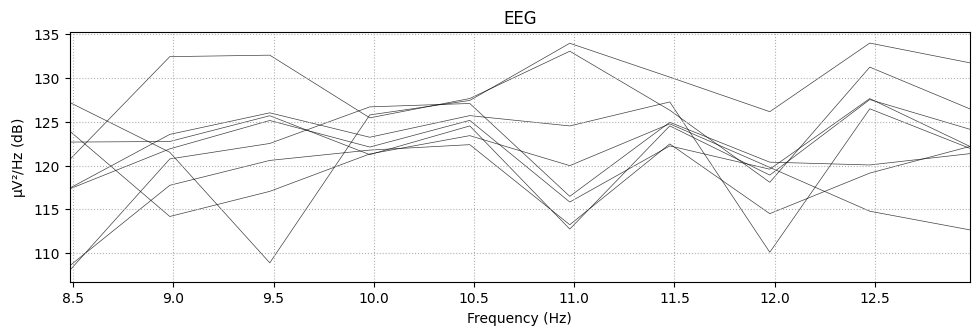

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.50
- Lower transition bandwidth: 3.38 Hz (-6 dB cutoff frequency: 11.81 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 245 samples (0.980 sec)



Channel locations not available. Disabling spatial colors.


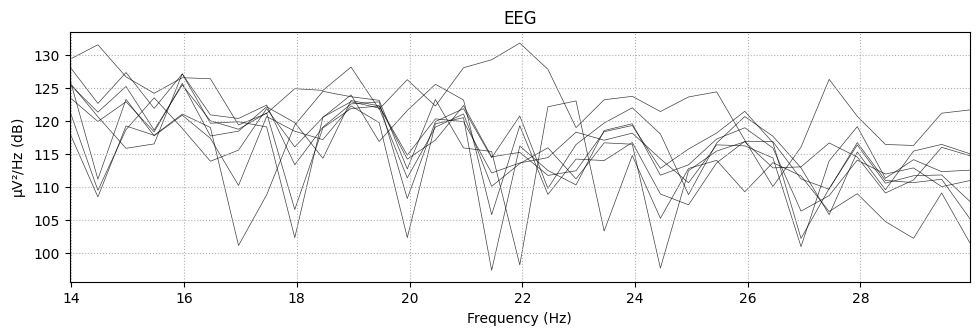

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 30 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.50
- Lower transition bandwidth: 7.62 Hz (-6 dB cutoff frequency: 26.69 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 109 samples (0.436 sec)



Channel locations not available. Disabling spatial colors.


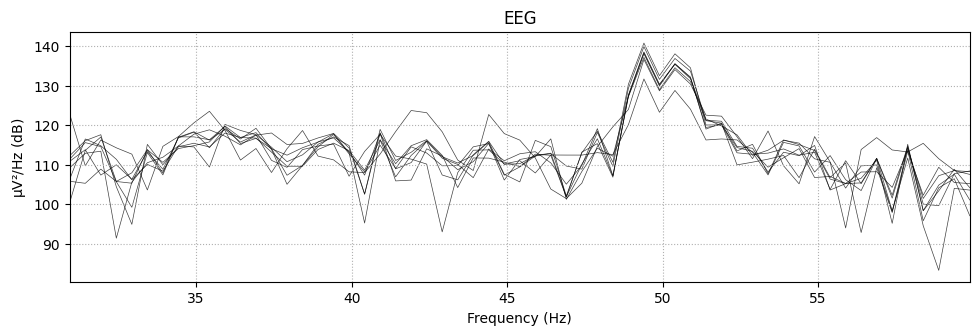

In [11]:
# plot relevant frequency bands

#specify participant
raw = current_baseline_mne_list[0]

# bands taken from slides
# other bands seem irrelevant as they indicate deep sleep, etc.
FREQ_BANDS = { 
                "alpha": [8, 13],
                "beta": [13.5, 30],
                "gamma": [30.5, 60],
            }

# apply notch filter to filter power line noise
freqs = (50, 100)
raw_notch = raw.copy().notch_filter(freqs=freqs, verbose=False, notch_widths=0.5)

# create psds for the relevant bands of the test data
raw_crop = raw_notch.copy().crop(tmin=0, tmax=2)
for band, freq in FREQ_BANDS.items():
    fmin, fmax = freq
    raw_filt = raw_crop.copy()
    raw_filt.filter(fmin, fmax, n_jobs=1)
    raw_filt.plot_psd(tmax=np.inf, fmin=fmin, fmax=fmax, verbose=False)


# Machine Learning

The following section contains:
* Feature creation using PSD (power spectral density) for different bands
* Testing different ML models
    * Support Vector Classifier (SVC)
    * Random Forst (RF)
    * Gradient Boosting Classifier
    * Xgboost
* Performing Grid Search and Cross Validation (CV)

In [12]:
# transform data into spectral domain

def eeg_power_band(raw: mne.io.RawArray):
    """EEG relative power band feature extraction.

    This function takes an ``mne.io.RawArray`` object and creates EEG features based
    on relative power in specific frequency bands that are compatible with
    scikit-learn.

    Parameters
    ----------
    raw : RawArray
        The data.

    Returns
    -------
    X : numpy array of shape [n_samples, 5]
        Transformed data.
    """

    # bands taken from slides
    fmin=8
    fmax=60
    FREQ_BANDS = {
        "alpha": [8, 13],
        "beta": [13.5, 30],
        "gamma": [30.5, 60],
    }

    psds, freqs = psd_welch(raw, picks="eeg", fmin=fmin, fmax=fmax, verbose=False)

    # Normalize the PSDs
    # Baseline in time dimension not neccessary (0th PSD dimension)
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        # use statistical features (mean, min, max, var)
        psds_mean = psds[:, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        psds_min = psds[:, (freqs >= fmin) & (freqs < fmax)].min(axis=-1)
        psds_max = psds[:, (freqs >= fmin) & (freqs < fmax)].max(axis=-1)
        psds_var = psds[:, (freqs >= fmin) & (freqs < fmax)].var(axis=-1)
        X.append(psds_mean.reshape(len(psds), -1))
        X.append(psds_min.reshape(len(psds), -1))
        X.append(psds_max.reshape(len(psds), -1))
        X.append(psds_var.reshape(len(psds), -1))
        # FURTHER IDEA: use smaller bins (e.g. 2 Hz range)

    return np.concatenate(X, axis=-2).squeeze()  # concatenate all 8 channels * 3 frequences


In [13]:
# Create features and labels for the ML models

def create_ml_data(trials, step=2):
    """ Create feature and class list for a given set of experiment trials

    Parameters
    ----------
    trial : dict
        Experiment trials categorized into treatments.
    step : int
        Timespan for the single observations

    Returns
    -------
    X : list
        List of features for all observations
    y : list
        List of classes for all observations
    """
    X = []
    y = []
    for data_class, data_list in trials.items():
        for raw in data_list:

            # apply notch filter
            freqs = (50, 100)
            raw_notch = raw.copy().notch_filter(freqs=freqs, verbose=False, notch_widths=0.5)

            # slice and create psd
            for start in range(0, int(raw.tmax), step):
                raw_crop = raw_notch.copy().crop(tmin=start, tmax=start+step)
                X.append(eeg_power_band(raw_crop))
                y.append(data_class)

    return X, y

# Test function
X, y = create_ml_data(trials)

# Show first observation and its dimension
print(X[:1], "total length:", len(X)) # 8 channels * 5 values
print(y[:1], "total length:", len(y))


[array([7.28744991e-02, 4.50944180e-02, 1.02333470e-02, 3.09393872e-02,
       1.03141196e-03, 1.14623127e-02, 1.30605808e-03, 1.16824083e-02,
       2.03175932e-02, 8.55511095e-03, 3.80826685e-03, 5.70391109e-03,
       5.19539438e-04, 9.81533485e-03, 8.66524289e-04, 8.68257846e-03,
       2.13488214e-01, 7.78620505e-02, 1.59630794e-02, 7.17179187e-02,
       1.59122830e-03, 1.47156372e-02, 2.34486795e-03, 1.40240811e-02,
       5.22631688e-03, 7.49879050e-04, 1.69391856e-05, 5.13903769e-04,
       1.27064852e-07, 3.25389755e-06, 2.85683106e-07, 3.65886834e-06,
       2.30067317e-02, 1.46953901e-02, 4.41285410e-03, 9.00720226e-03,
       6.47273984e-04, 8.68804609e-03, 6.65157271e-04, 5.97830247e-03,
       3.65289568e-03, 2.03166172e-03, 1.68015795e-04, 1.83582065e-03,
       5.19308890e-05, 9.25436628e-04, 5.37123170e-05, 6.20122011e-04,
       4.33039763e-02, 3.65646356e-02, 1.11151961e-02, 1.76450154e-02,
       1.56834807e-03, 2.43811594e-02, 2.09770215e-03, 1.79662041e-02,
     

In [14]:
# Support Vector Classifier
clf = SVC(kernel= 'poly', random_state=42, C=0.1) # linear, sigmoid and rbf kernel perform even worse

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Train
clf.fit(X_train, y_train)

# Test
y_pred = clf.predict(X_test)

# Assess the results
acc = accuracy_score(y_test, y_pred)

print("Accuracy score: {}".format(acc))
print(classification_report(y_test, y_pred, target_names=trials.keys()))
print(confusion_matrix(y_test, y_pred))

Accuracy score: 0.32
                   precision    recall  f1-score   support

             ball       0.26      0.92      0.41        12
      ball+number       0.67      0.12      0.20        17
ball+number+wheel       0.00      0.00      0.00        17
         baseline       0.75      0.75      0.75         4

         accuracy                           0.32        50
        macro avg       0.42      0.45      0.34        50
     weighted avg       0.35      0.32      0.23        50

[[11  0  0  1]
 [14  2  1  0]
 [17  0  0  0]
 [ 0  1  0  3]]


Accuracy score: 0.5
                   precision    recall  f1-score   support

             ball       0.39      0.58      0.47        12
      ball+number       0.64      0.53      0.58        17
ball+number+wheel       0.42      0.29      0.34        17
         baseline       0.67      1.00      0.80         4

         accuracy                           0.50        50
        macro avg       0.53      0.60      0.55        50
     weighted avg       0.51      0.50      0.49        50

[[7 2 2 1]
 [2 9 5 1]
 [9 3 5 0]
 [0 0 0 4]]


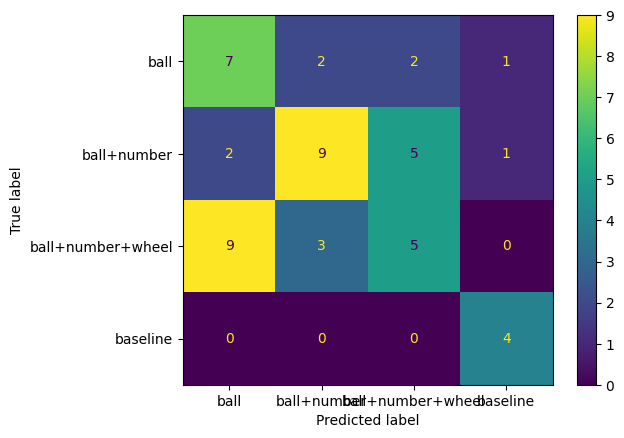

In [15]:
# Random forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Train
clf.fit(X_train, y_train)

# Test
y_pred = clf.predict(X_test)

# Assess the results
acc = accuracy_score(y_test, y_pred)

print("Accuracy score: {}".format(acc))
print(classification_report(y_test, y_pred, target_names=trials.keys()))
print(confusion_matrix(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels = clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()

In [16]:
# Gradient Boosting Classifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Train
clf.fit(X_train, y_train)

# Test
y_pred = clf.predict(X_test)

# Assess the results
acc = accuracy_score(y_test, y_pred)

print("Accuracy score: {}".format(acc))
print(classification_report(y_test, y_pred, target_names=trials.keys()))
print(confusion_matrix(y_test, y_pred))

Accuracy score: 0.44
                   precision    recall  f1-score   support

             ball       0.46      0.50      0.48        12
      ball+number       0.47      0.41      0.44        17
ball+number+wheel       0.41      0.41      0.41        17
         baseline       0.40      0.50      0.44         4

         accuracy                           0.44        50
        macro avg       0.43      0.46      0.44        50
     weighted avg       0.44      0.44      0.44        50

[[6 2 3 1]
 [1 7 7 2]
 [6 4 7 0]
 [0 2 0 2]]


In [17]:
# Xgboost
clf = xgb.sklearn.XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    eval_metric='logloss',
    # tree_method="gpu_hist", # no gpu present
    )

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_numeric = le.fit_transform(y)
y_numeric

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_numeric, random_state=42)

# Train
clf.fit(X_train, y_train)

# Test
y_pred = clf.predict(X_test)

# Assess the results
acc = accuracy_score(y_test, y_pred)

print("Accuracy score: {}".format(acc))
print(classification_report(y_test, y_pred, target_names=trials.keys()))
print(confusion_matrix(y_test, y_pred))

Accuracy score: 0.44
                   precision    recall  f1-score   support

             ball       0.27      0.33      0.30        12
      ball+number       0.60      0.71      0.65        17
ball+number+wheel       0.22      0.12      0.15        17
         baseline       0.67      1.00      0.80         4

         accuracy                           0.44        50
        macro avg       0.44      0.54      0.47        50
     weighted avg       0.40      0.44      0.41        50

[[ 4  4  4  0]
 [ 0 12  3  2]
 [11  4  2  0]
 [ 0  0  0  4]]


In [18]:
# Parameter search for Xgboost
# We limit this to the bare minimum, as we have limited ressources (time and hardware)

clf = xgb.sklearn.XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    eval_metric='logloss',
    # tree_method="gpu_hist", # no gpu present
    )

param_grid = {
    'learning_rate': [0.2],# [.1, 0.2, 0.4],  # `eta` value
    #'max_depth': [4, 6, 8],
    #'min_child_weight': [1, 3, 5, 10],
    #'subsample': [0.7, 1],
    #'colsample_bytree': [0.7, 1],
    'n_estimators': [100], #[10, 20, 50, 100],
    #'gamma': [0.5, 1, 2]
}

mycv = StratifiedKFold(n_splits=10)

grid = GridSearchCV(
    clf,
    param_grid,
    refit='accuracy',
    verbose=1,
    scoring=['accuracy'],
    cv=mycv
)


from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_numeric = le.fit_transform(y)

grid.fit(X, y_numeric) # takes too long

print(grid.best_params_)
print(grid.best_score_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
{'learning_rate': 0.2, 'n_estimators': 100}
0.495


In [19]:
# Cross validation for all single participants and the whole group

clf = RandomForestClassifier(n_estimators=100, random_state=42)

param_grid = {
    "n_estimators": [100], #takes too long for big n of estimators, e.g. 1000!
}

mycv = StratifiedKFold(n_splits=10)

grid = GridSearchCV(
    clf,
    param_grid,
    refit='accuracy',
    verbose=1,
    scoring=['accuracy'],
    cv=mycv
)

le = LabelEncoder()

# make predictions for all participants individually
for i, current in enumerate(baseline_list):
    current_baseline_list = [current]
    current_experiment_list = [experiment_list[i]]
    participant = re.findall(r"sub-(\w*)_ses", current_baseline_list[0])[0]

    trials = read_trails(current_experiment_list, current_baseline_list)
    X, y = create_ml_data(trials)

    y_numeric = le.fit_transform(y)
    grid.fit(X, y_numeric)
    print(f'best accuracy for {participant} : {round(grid.best_score_, 2)}') # Mean cross-validated score of the best_clf

# make predictions for all participants collectively
current_baseline_list = baseline_list
current_experiment_list = experiment_list

trials = read_trails(current_experiment_list, current_baseline_list)
X, y = create_ml_data(trials)

y_numeric = le.fit_transform(y)
grid.fit(X, y_numeric)
print(f'mean accuracy for all participants : {round(grid.best_score_, 2)}')


Fitting 10 folds for each of 1 candidates, totalling 10 fits
best accuracy for Tobias : 0.46
Fitting 10 folds for each of 1 candidates, totalling 10 fits
best accuracy for Karla : 0.37
Fitting 10 folds for each of 1 candidates, totalling 10 fits
best accuracy for Jonah : 0.45
Fitting 10 folds for each of 1 candidates, totalling 10 fits
best accuracy for Hussan : 0.38
Fitting 10 folds for each of 1 candidates, totalling 10 fits
best accuracy for Gaffar : 0.38
Fitting 10 folds for each of 1 candidates, totalling 10 fits
best accuracy for Christian : 0.46
Fitting 10 folds for each of 1 candidates, totalling 10 fits
best accuracy for Aljoscha : 0.42
Fitting 10 folds for each of 1 candidates, totalling 10 fits
best accuracy for Oskar : 0.55
Fitting 10 folds for each of 1 candidates, totalling 10 fits
best accuracy for Timo : 0.37
Fitting 10 folds for each of 1 candidates, totalling 10 fits
mean accuracy for all participants : 0.32


In [20]:
# # Cross Validation for Gradient Boosting 
# # Takes too long!!
# clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=3, random_state=42)

# param_grid = {
#     "learning_rate": [0.2],
#     "n_estimators": [100], #takes too long for big n of estimators, e.g. 1000!
# }

# mycv = StratifiedKFold(n_splits=10)

# grid = GridSearchCV(
#     clf,
#     param_grid,
#     refit='accuracy',
#     verbose=1,
#     scoring=['accuracy'],
#     cv=mycv
# )

# le = LabelEncoder()

# # make predictions for all participants individually
# for i, current in enumerate(baseline_list):
#     current_baseline_list = [current]
#     current_experiment_list = [experiment_list[i]]
#     participant = re.findall(r"sub-(\w*)_ses", current_baseline_list[0])[0]

#     trials = read_trails(current_experiment_list, current_baseline_list)
#     X, y = create_ml_data(trials)

#     y_numeric = le.fit_transform(y)
#     grid.fit(X, y_numeric)
#     print(f'best accuracy for {participant} : {round(grid.best_score_, 2)}') # Mean cross-validated score of the best_estimator

# # make predictions for all participants collectively
# current_baseline_list = baseline_list
# current_experiment_list = experiment_list

# trials = read_trails(current_experiment_list, current_baseline_list)
# X, y = create_ml_data(trials)

# y_numeric = le.fit_transform(y)

# grid.fit(X, y_numeric)
# print(f'mean accuracy for all participants : {round(grid.best_score_, 2)}')


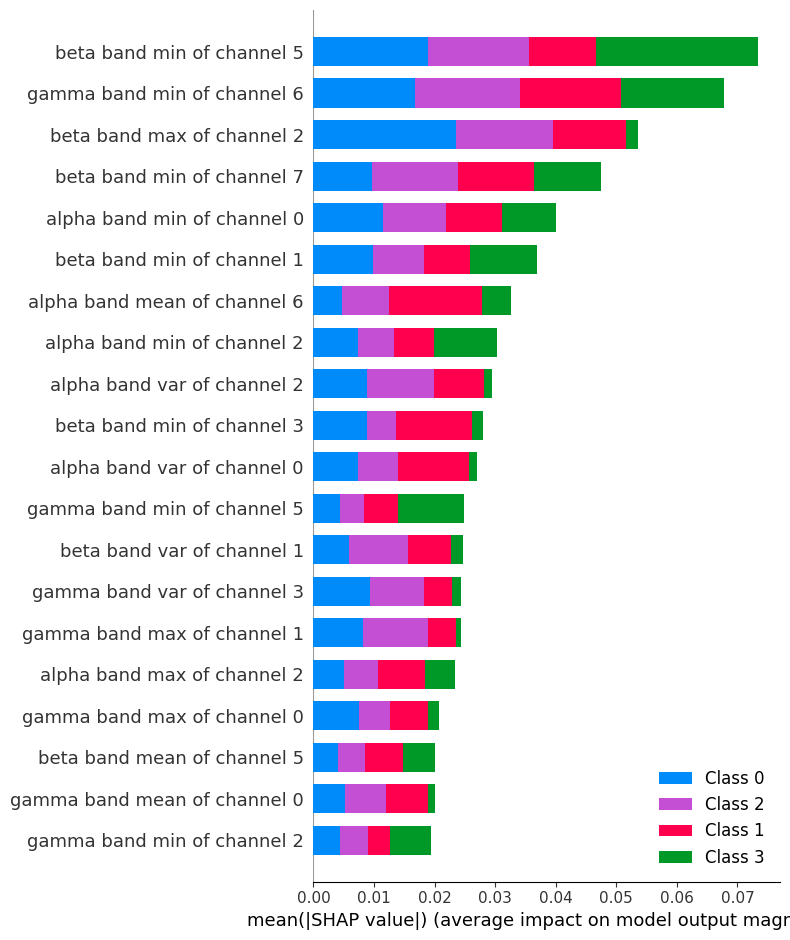

In [24]:
# Feature importance for the whole group
# Attempt: Compute the SHAP values for the model

# Create feature name list
feature_labels = list()
for channel, band  in product(range(8), ['alpha', 'beta', 'gamma']):
    feature_labels += [f'{band} band mean of channel {channel}', f'{band} band min of channel {channel}', f'{band} band max of channel {channel}', f'{band} band var of channel {channel}']

# Load data for first participant
trials = read_trails([current_experiment_list[0]], [current_baseline_list[0]])
X, y = create_ml_data(trials)

# Refit random forest clf and make prediction
clf = RandomForestClassifier(n_estimators=100, random_state=42)
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
# Train
clf.fit(X_train, y_train)

samples = np.array(X_train)

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(samples, approximate=False, check_additivity=False)
shap.summary_plot(shap_values, feature_names=feature_labels)


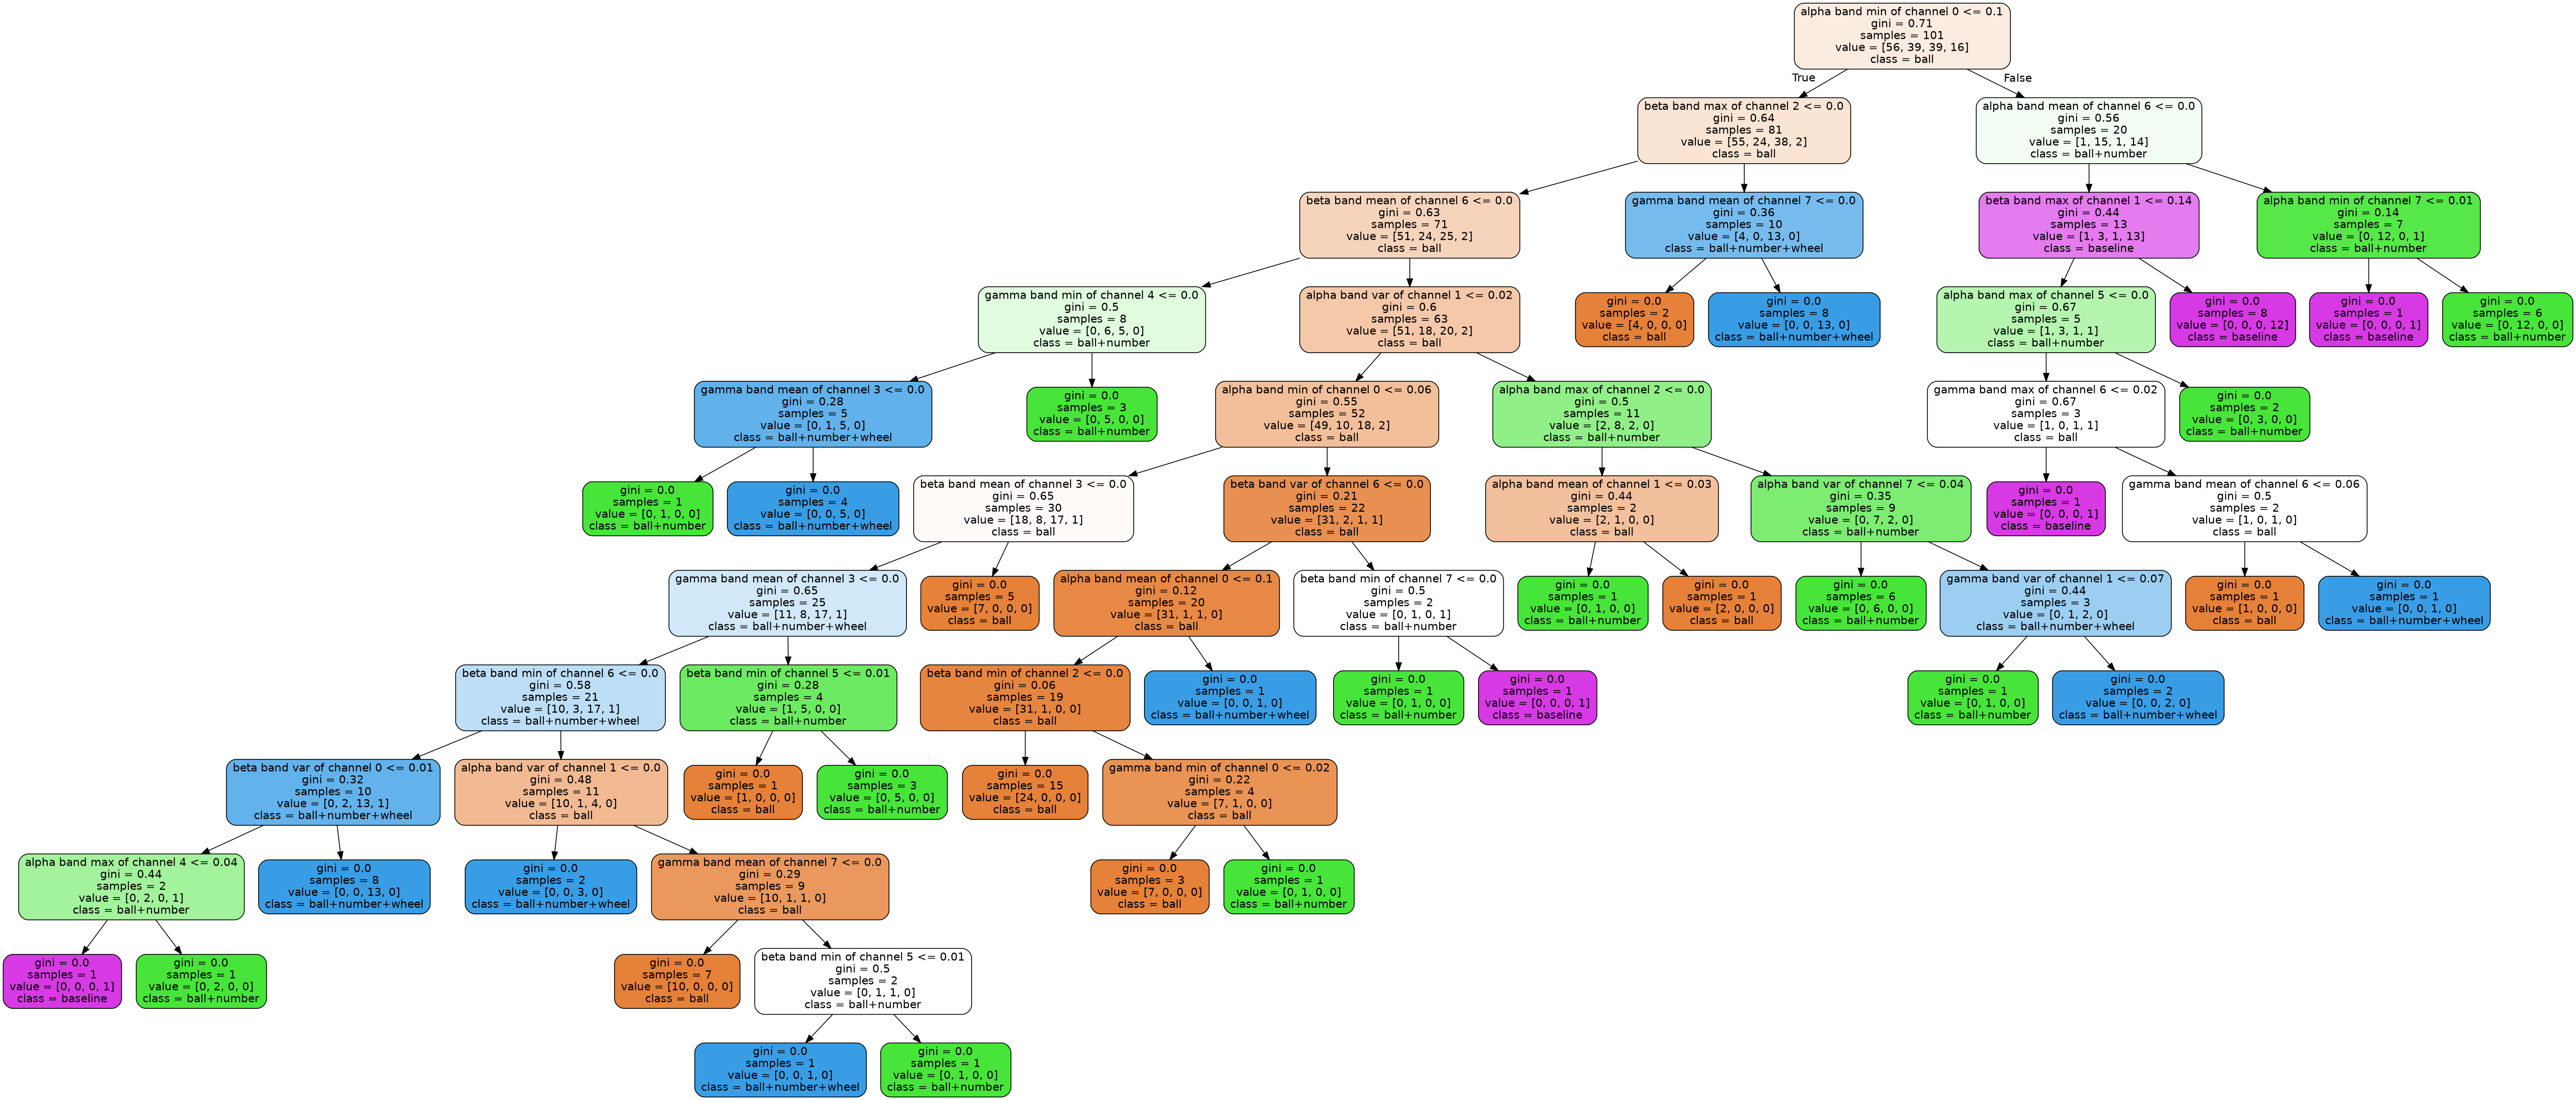

In [22]:
# Visualize one of the decision trees for the whole grouop

class_names = ['ball', 'ball+number', 'ball+number+wheel', 'baseline']

# Export as dot file
tree = clf.estimators_[0]
export_graphviz(tree, out_file='tree.dot', 
                feature_names = feature_labels,
                class_names = class_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz, see https://graphviz.org/)
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=150'])

# Display in jupyter notebook
Image(filename = 'tree.png')

# Online Evaluation System

We created a frontend for real-time prediction.

To realize it, we used:
* Pylsl to receive the data in real time
* Websocket to showcase transmission of the data from the capture device to a remote location
* Django for the Backend and Chartjs for the visualization

Following screenshots show our prototype:

<img src="dashboard_screenshot01.PNG" alt="Dashboard" title="Dashboard Prototype" width="800"/>

To start the Sytem the following steps are to follow:

* To send the received data from the eeg device you have to start the Script in the /dashboard/websocket folder.
* Start the django backend with "python manage.py runserver" and then navigate to "localhost:port/csl/". 
###### Note: to receive and send the data to the dashboard you have to connect your device to the laptop with unicorn lsl